In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [51]:
df = pd.read_csv('XYZ_sports_dataset.csv', sep=";")
df.head()

,ID,Age,Gender,Income,EnrollmentStart,EnrollmentFinish,LastPeriodStart,LastPeriodFinish,DateLastVisit,DaysWithoutFrequency,...,OtherActivities,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisitsBySLA,AllowedNumberOfVisitsBySLA,RealNumberOfVisits,NumberOfRenewals,HasReferences,NumberOfReferences,Dropout
0,10000,60,Female,5500.0,2019-09-03,2019-10-31,2019-07-01,2019-12-31,2019-10-30,1,...,0.0,9.0,7,NaN,6.28,2,0,0.0,0,0
1,10001,29,Female,2630.0,2014-08-12,2015-09-14,2015-01-01,2015-12-31,2015-07-16,60,...,0.0,23.0,1,2.0,17.42,1,2,0.0,0,1
2,10002,23,Male,1980.0,2017-05-02,2017-06-01,2017-01-01,2017-06-30,2017-05-25,7,...,0.0,6.0,0,7.0,30.03,6,0,0.0,0,1
3,10003,9,Male,0.0,2018-09-05,2019-02-12,2018-07-01,2019-06-30,2019-01-21,22,...,0.0,20.0,2,2.0,17.72,3,0,0.0,0,1
4,10004,35,Male,4320.0,2016-04-20,2018-06-07,2018-01-01,2018-06-30,2017-11-09,210,...,NaN,41.0,0,7.0,60.97,0,3,0.0,0,1


In [52]:
df.shape

(14942, 31)

## Handling Duplicates

In [53]:
df.duplicated().sum()

0

In [54]:
df.drop_duplicates(inplace=True)

## Fixing column types

In [55]:
df.dtypes

ID                              int64
Age                             int64
Gender                         object
Income                        float64
EnrollmentStart                object
EnrollmentFinish               object
LastPeriodStart                object
LastPeriodFinish               object
DateLastVisit                  object
DaysWithoutFrequency            int64
LifetimeValue                 float64
UseByTime                       int64
AthleticsActivities           float64
WaterActivities               float64
FitnessActivities             float64
DanceActivities               float64
TeamActivities                float64
RacketActivities              float64
CombatActivities              float64
NatureActivities              float64
SpecialActivities             float64
OtherActivities               float64
NumberOfFrequencies           float64
AttendedClasses                 int64
AllowedWeeklyVisitsBySLA      float64
AllowedNumberOfVisitsBySLA    float64
RealNumberOf

We can see that the date columns are being represented as "object", so we need to fix it.

In [56]:
df["EnrollmentStart"] = pd.to_datetime(df["EnrollmentStart"])
df["EnrollmentFinish"] = pd.to_datetime(df["EnrollmentFinish"])
df["LastPeriodStart"] = pd.to_datetime(df["LastPeriodStart"])
df["LastPeriodFinish"] = pd.to_datetime(df["LastPeriodFinish"])
df["DateLastVisit"] = pd.to_datetime(df["DateLastVisit"])

DateLastVisit looks like other columns in the dataset.
We'll check the correlation between them to see if we can drop it.

In [57]:
df[["EnrollmentFinish", "LastPeriodFinish", "DateLastVisit"]].corr()

,EnrollmentFinish,LastPeriodFinish,DateLastVisit
EnrollmentFinish,1.000000,0.770579,0.750199
LastPeriodFinish,0.770579,1.000000,0.982803
DateLastVisit,0.750199,0.982803,1.000000


In the end the DateLastVisit is highly correlated with the LastPeriodFinish, so we'll drop it.

In [58]:
df.drop("DateLastVisit", axis=1, inplace=True)

Now we can do some feature engineering to create new columns that represent the duration of enrollment and last period
in order to reduce dimensionality.

In [59]:
df["EnrollmentDurationInDays"] = (df["EnrollmentFinish"] - df["EnrollmentStart"]).dt.days
df["LastPeriodDurationInDays"] = (df["LastPeriodFinish"] - df["LastPeriodStart"]).dt.days

df.drop(["EnrollmentStart", "EnrollmentFinish", "LastPeriodStart", "LastPeriodFinish"], axis=1, inplace=True)

The gender column is also being represented as "object" and should be categorical.

In [60]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == "Male" else 0)

We can see that the columns "DanceActivities" and "NatureActivities" only have zeroes.
As they fall into activities that are not used by any custom, we'll drop them.

Also, the ID column is not useful for our analysis, so we'll drop it too.

Lastly, we'll drop the "HasReferences" column as it is already being represented by the "NumberOfReferences" column.

In [61]:
columns_to_drop = [
    'DanceActivities',
    'NatureActivities',
    'ID',
    'HasReferences'
]
df.drop(columns_to_drop, axis=1, inplace=True)

In [62]:
categorical_features = [
    "Gender",
    "UseByTime",
    "AthleticsActivities",
    "WaterActivities",
    "FitnessActivities",
    "TeamActivities",
    "RacketActivities",
    "CombatActivities",
    "SpecialActivities",
    "OtherActivities",
    "Dropout"
]

numeric_features = [
    "Age",
    "Income",
    "EnrollmentDurationInDays",
    "LastPeriodDurationInDays",
    "DaysWithoutFrequency",
    "LifetimeValue",
    "NumberOfFrequencies",
    "AttendedClasses",
    "AllowedWeeklyVisitsBySLA",
    "AllowedNumberOfVisitsBySLA",
    "RealNumberOfVisits",
    "NumberOfRenewals",
    "NumberOfReferences"
]

## Handling missing values
TODO

In [63]:
df.isna().sum() / df.shape[0] * 100 

Age                           0.000000
Gender                        0.000000
Income                        3.312810
DaysWithoutFrequency          0.000000
LifetimeValue                 0.000000
UseByTime                     0.000000
AthleticsActivities           0.240932
WaterActivities               0.247624
FitnessActivities             0.234239
TeamActivities                0.234239
RacketActivities              0.247624
CombatActivities              0.220854
SpecialActivities             0.294472
OtherActivities               0.234239
NumberOfFrequencies           0.174006
AttendedClasses               0.000000
AllowedWeeklyVisitsBySLA      3.580511
AllowedNumberOfVisitsBySLA    0.000000
RealNumberOfVisits            0.000000
NumberOfRenewals              0.000000
NumberOfReferences            0.000000
Dropout                       0.000000
EnrollmentDurationInDays      0.000000
LastPeriodDurationInDays      0.000000
dtype: float64

Among continuous variables, only the `Income`, `AllowedWeeklyVisitsBySLA` and `NumberOfFrequencies` columns contain missing values.
We'll drop the rows with missing values.
<span color="red">TODO: AFTER FIRST ITERATION OF CLUSTERING, CHECK HOW INPUTING WILL CHANGE THE SHAPE OF CLUSTERS</span>

In [64]:
df.dropna(inplace=True)

# Outlier detection
TODO

Income                           Axes(0.125,0.747241;0.133621x0.132759)
EnrollmentDurationInDays      Axes(0.285345,0.747241;0.133621x0.132759)
LastPeriodDurationInDays       Axes(0.44569,0.747241;0.133621x0.132759)
DaysWithoutFrequency          Axes(0.606034,0.747241;0.133621x0.132759)
LifetimeValue                 Axes(0.766379,0.747241;0.133621x0.132759)
NumberOfFrequencies              Axes(0.125,0.587931;0.133621x0.132759)
AttendedClasses               Axes(0.285345,0.587931;0.133621x0.132759)
AllowedWeeklyVisitsBySLA       Axes(0.44569,0.587931;0.133621x0.132759)
AllowedNumberOfVisitsBySLA    Axes(0.606034,0.587931;0.133621x0.132759)
RealNumberOfVisits            Axes(0.766379,0.587931;0.133621x0.132759)
NumberOfRenewals                 Axes(0.125,0.428621;0.133621x0.132759)
NumberOfReferences            Axes(0.285345,0.428621;0.133621x0.132759)
dtype: object

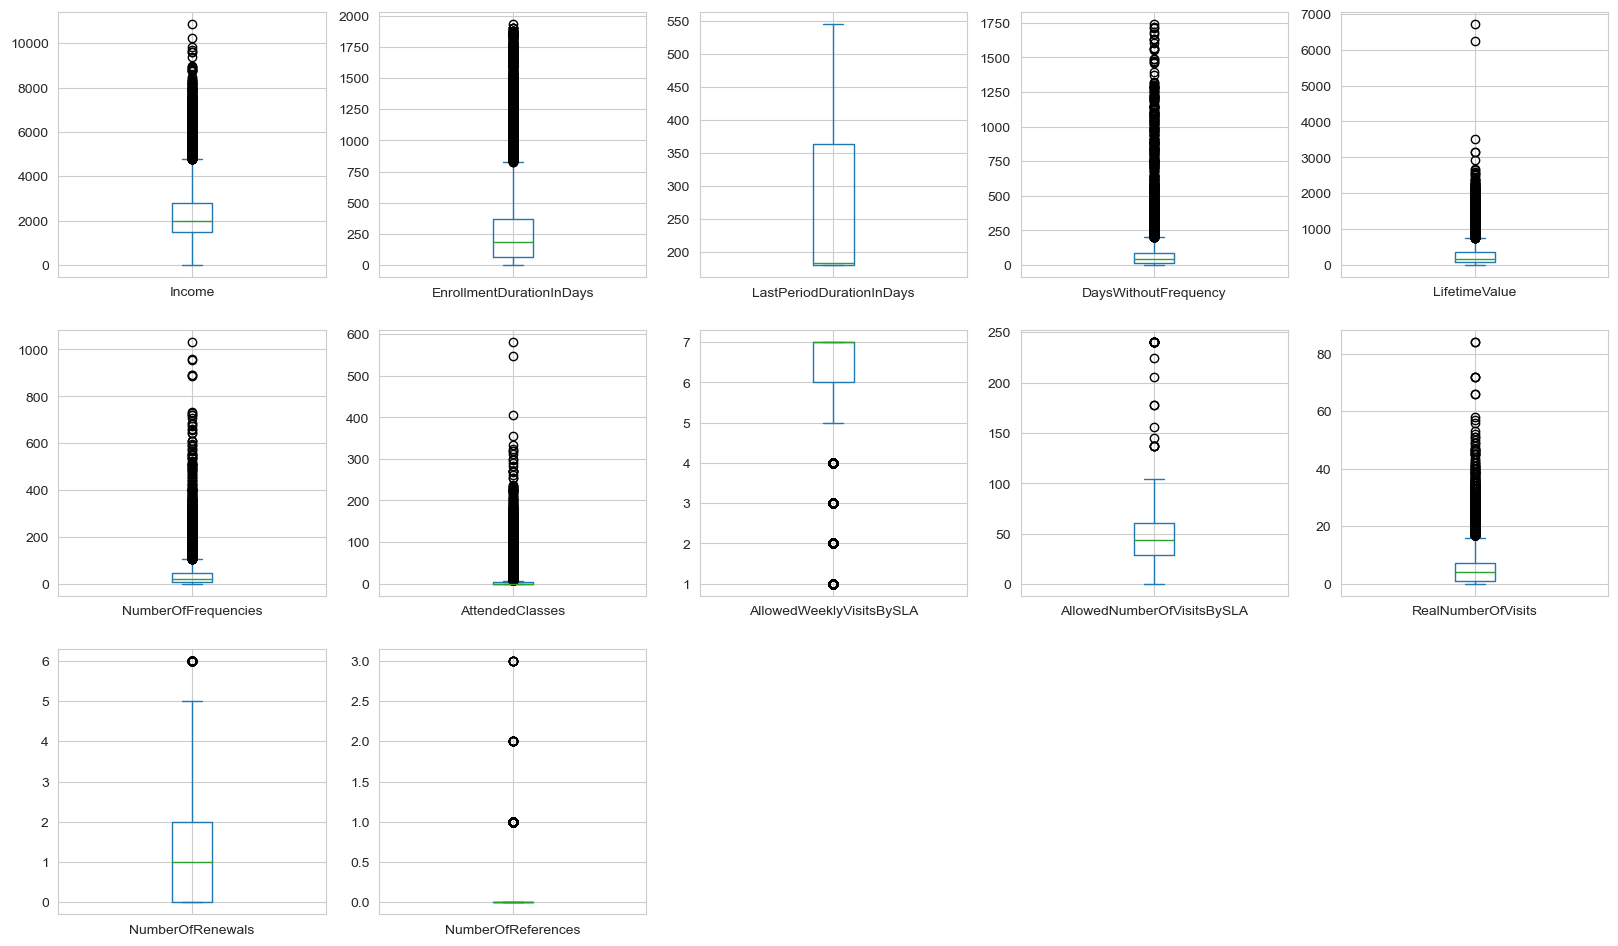

In [71]:
# df[numeric_features].plot(kind='box', subplots=True, layout=(5, 5), figsize=(20, 20))

## Checking numeric features correlations

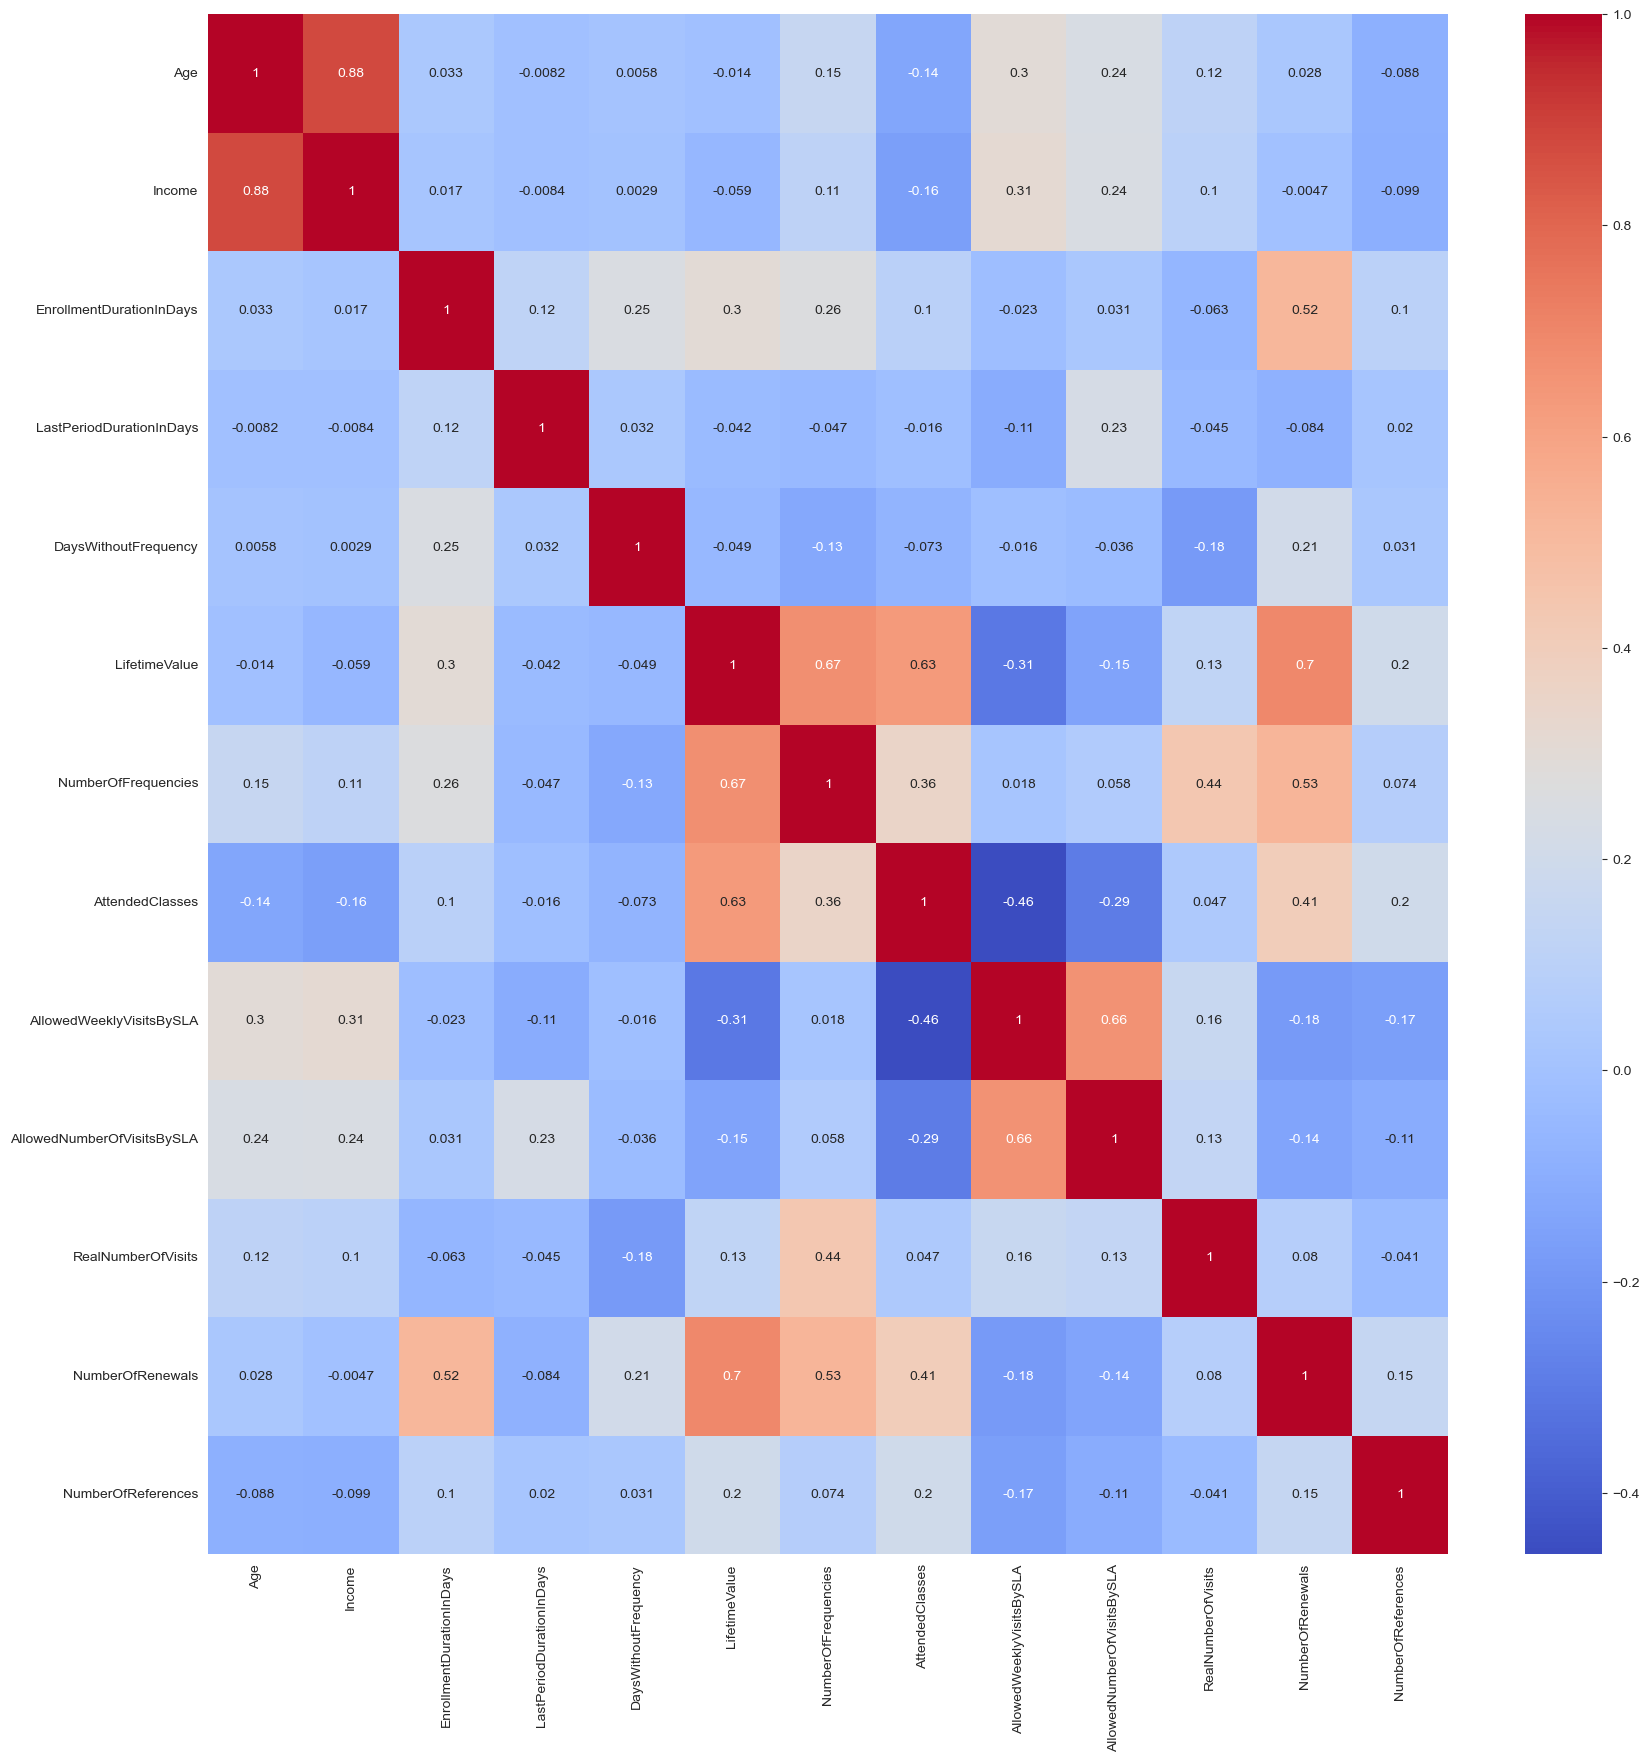

In [66]:
%matplotlib inline
corr = df[numeric_features].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [67]:
df.drop('Age', axis=1, inplace=True)
numeric_features.remove('Age')

## Pairwise plot for numeric features

# Feature Engineering / Selection
TODO:

# Feature Scaling

In [68]:
scaler = MinMaxScaler()
scaled_df = df.copy()
scaled_numeric_features = scaler.fit_transform(df[numeric_features])

scaled_df[numeric_features] = scaled_numeric_features

# <span style="color:red">WE NEED TO DO MORE PREPROCESSING AFTER CLUSTERING</span>

# Clustering

In [74]:
def show_clusters(model, features):
    clusters = model.fit_predict(scaled_df[features])
    
    unscaled_numeric_features = pd.DataFrame(scaler.inverse_transform(scaled_df[features]))
    unscaled_numeric_features.columns = df[features].columns
    df_clusters = pd.concat([unscaled_numeric_features, pd.Series(clusters, name='labels', index=unscaled_numeric_features.index)], axis=1)
    
    return df_clusters.groupby('labels').mean()

In [75]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

kmeans_df = show_clusters(kmeans, numeric_features)
kmeans_df.T

/Users/carlos.costa/anaconda3/envs/DM2324/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


labels,0,1,2,3,4
Income,1207.706113,2457.069825,2818.805591,1583.320210,2434.599491
EnrollmentDurationInDays,210.077398,176.673139,903.604828,413.005906,238.087413
LastPeriodDurationInDays,182.126192,181.420556,237.473316,368.309055,365.497139
DaysWithoutFrequency,64.974762,74.071963,151.454257,111.556430,68.300699
LifetimeValue,583.188822,160.807389,647.383037,398.194934,183.931621
NumberOfFrequencies,45.445878,27.280549,116.957433,31.593176,30.297521
AttendedClasses,39.563096,0.794086,10.083863,26.682415,1.022250
AllowedWeeklyVisitsBySLA,2.347168,6.989312,6.863405,2.198163,6.985378
AllowedNumberOfVisitsBySLA,18.079849,44.754316,50.631773,20.392349,59.925102
RealNumberOfVisits,4.057207,5.720164,6.864676,3.076115,5.570884


# <span style="color:red">REVERSE SCALING BEFORE EVALUATING CLUSTERS</span>

# Checking results (double check it with ChatGPT later)
## View results
- Check if the cluster center (mean) of any variables doesn't vary much between clusters, if so, we can drop it.
- If there are clusters with too few customers, we can check if the center of the variables is similar to the other clusters, if so, we can merge them.


## Visualization
- We can plot cluster centers:
```python
df.groupby('labels') \ [scaled_features].mean().plot(kind='bar')
```

# Feature reduction
- Factor Analysis
- Multidimensional scaling
```